C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\user\anaconda3\envs\env_mlf\Lib\site-packages\spyder_kernels\customize\spydercustomize.py", line 47, in __init__
    super(SubprocessPopen, self).__init__(*args, **kwargs)
  File "C:\Users\user\anaconda3\envs\e

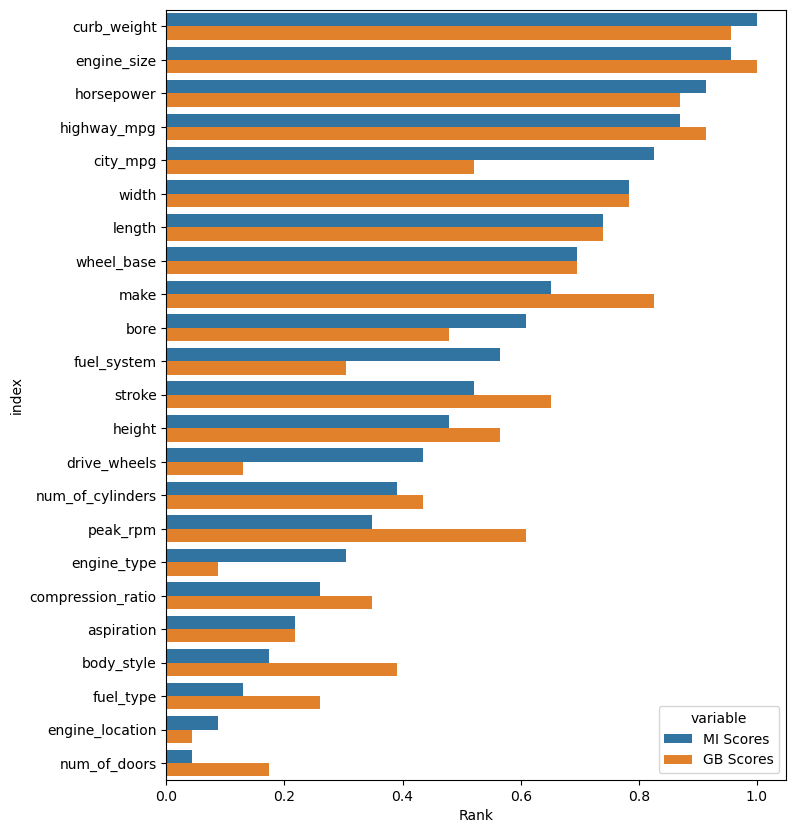

'\n- результати показують, що «корисність» окремих ознак може значно варіюватися в залежності від методу оцінки. Це підкреслює важливість використання різних підходів для комплексного аналізу даних і підвищення якості прогнозних моделей.\n- Деякі ознаки з високим показником MI не завжди мають високу важливість у моделі.\n- Наприклад, ознака з низькою MI може бути важливою у взаємодії з іншими ознаками, як показує RandomForest.\n'

In [3]:
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

#%%
# Завантаження даних
with open('../datasets/mod_05_topic_10_various_data.pkl', 'rb') as fl:
    datasets = pickle.load(fl)

autos = datasets['autos']
X = autos.copy()
y = X.pop('price')

#%%
# Визначаємо категоріальні ознаки
cat_features = X.select_dtypes(include='object').columns

# Кодуємо дискретні ознаки за допомогою LabelEncoder або factorize
for col in cat_features:
    X[col], _ = X[col].factorize()

# Визначаємо додаткові числові дискретні ознаки
discrete_features = ['num_of_doors', 'num_of_cylinders']

#%%
# Розрахунок показників взаємної інформації (MI)
mi_scores = mutual_info_regression(
    X, y,
    discrete_features=X.columns.isin(cat_features.to_list() + discrete_features),
    random_state=42
)
mi_scores = pd.Series(mi_scores, name='MI Scores', index=X.columns).sort_values(ascending=False)

#%%
# Побудова регресійної моделі для оцінки важливості ознак
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X, y)

# Оцінка важливості ознак
feature_importances = pd.Series(model.feature_importances_, name='GB Scores', index=X.columns).sort_values(ascending=False)

#%%
# Масштабування та уніфікація показників
mi_scores_ranked = mi_scores.rank(pct=True)
feature_importances_ranked = feature_importances.rank(pct=True)

# Об'єднуємо дані для порівняння
comparison_df = pd.DataFrame({
    'MI Scores': mi_scores_ranked,
    'GB Scores': feature_importances_ranked
}).reset_index()

#%%
# Сортуємо дані за рангом взаємної інформації
comparison_df = comparison_df.sort_values(by='MI Scores', ascending=False)

# Використовуємо melt для створення "довгого" формату
comparison_melted = comparison_df.melt(id_vars='index', var_name='variable', value_name='Rank')

plt.figure(figsize=(8, 10))
sns.barplot(data=comparison_melted, x='Rank', y='index', hue='variable', dodge=True)
plt.show()

#%%
# 7. Висновки
"""
- результати показують, що «корисність» окремих ознак може значно варіюватися в залежності від методу оцінки. Це підкреслює важливість використання різних підходів для комплексного аналізу даних і підвищення якості прогнозних моделей.
- Деякі ознаки з високим показником MI не завжди мають високу важливість у моделі.
- Наприклад, ознака з низькою MI може бути важливою у взаємодії з іншими ознаками, як показує RandomForest.
"""
